# Detecting food in Hyperspectral Images of pasta with PCA

George Miliarakis, Research Practice Report

Hungry Robots Lab  
Wageningen University & Research


## Libraries


In [27]:
# os.environ["KERAS_BACKEND"] = "tensorflow"
from datetime import datetime
from packaging import version
import os, re
# import numbers
# import math
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import scipy.io as sio
import skimage
import skimage.io as io
import pandas as pd
import matplotlib.pyplot as plt
import spectral

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from keras.ops.image import crop_images, pad_images, extract_patches
from tensorflow.image import crop_to_bounding_box
from keras.utils import to_categorical

import keras_cv
import keras_tuner as kt
from tensorflow import keras
from keras import ops, saving
from keras.layers import *
from keras_cv.layers import *
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
# from patchify import *

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier 
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, RocCurveDisplay, classification_report, brier_score_loss, ConfusionMatrixDisplay,  jaccard_score

In [14]:
plt.style.use('seaborn-v0_8-colorblind')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams["figure.dpi"] = 150
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif"})

## Functions


In [15]:
# Visualization module
def spectra(i, mode = 'kmeans'):
    '''Function that plots the K-means spectra of food and bg '''
    img = spectral.envi.open(f'envi/m{i}_corrected_cropped_c64_r118_w272_h407.hdr', f'envi/m{i}_corrected_cropped_c64_r118_w272_h407.bin').load()
    plt.close('all')
    if mode=='kmeans':
        plt.figure(figsize=(6,4))
        m, c= spectral.kmeans(img, 2, 20)
        bg = np.where(m.T==1)
        fg = np.where(m.T==0)
        for j in range(c.shape[0]):
            plt.plot(img.bands.centers, c[j])
        plt.legend(['food','background'])
        plt.title(f'Sample {i}: mean reflectance per KMeans cluster')
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Reflectance')
        plt.show()
    elif mode=='all':
        m, c= spectral.kmeans(img, 2, 20)
        bg = np.where(m.T==1)
        fg = np.where(m.T==0)
        fig, ax=plt.subplots()
        #fg spectra
        for i, j in zip(fg[0], fg[1]):
            food, = ax.plot(img.bands.centers, img[j, i], 'r', alpha=0.3)
        #bg spectra
        for i, j in zip(bg[0], bg[1]):
            back, = ax.plot(img.bands.centers, img[j, i], 'k', alpha=0.3)
        ax.legend(handles= (back, food), labels=('background','food'), loc=1)
        ax.set_xlabel('Wavelength (nm)')
        ax.set_ylabel('Reflectance')
        fig.show()
    elif mode=='pixel':
        plt.plot(img.bands.centers, img[pixel[1],pixel[0]])
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Reflectance')
        plt.show()

# Neural Network (NN) module

## NN evaluation
def evaluate(y, yhat):
    if y.ndim == 2:
        y = np.argmax(y, axis=1)
    if yhat.ndim ==2:
        yhat = np.argmax(yhat, axis=1)
    report=classification_report(y,  yhat, digits=5, output_dict=True, zero_division = 0)
    metrics = pd.DataFrame(report)
    metrics.drop('support', axis=0, inplace=True)
    metrics.loc[len(metrics.index)] = metrics.iloc[0,2]
    metrics.drop(metrics.columns[0:4], axis=1, inplace=True)
    metrics.rename(index={3:'accuracy'}, inplace=True)
    metrics.loc[len(metrics.index)] = [roc_auc_score(y,yhat)]
    metrics.rename(index={4:'AUC'}, inplace=True)
    metrics.loc[len(metrics.index)] = [jaccard_score(y,  yhat)]
    metrics.rename(index={5:'Jaccard score (IoU)'}, inplace=True)
    metrics.loc[len(metrics.index)] = [brier_score_loss(y,yhat)]
    metrics.rename(index={6:'Brier score'}, inplace=True)
    metrics.sort_index(inplace=True)
    return metrics
    
## NN testing
def find_food(i, plot = False):
    '''Wrapper function to detect edges in sample i using the NN. '''
    X, y = load(i)
    print(f"Loaded HSI cube and ground truth #{i}\n")
    y = 1-y
    X, y = cubify(X, y, size = 25)
    # print(f"New X shape:{X.shape}, \nNew y shape:{y.shape}")  
    y = to_categorical(y)
    model = saving.load_model('mask.keras')
    model.compile(
        optimizer=SGD(learning_rate= 0.009893539816323986,
        momentum= 0.03610159534573816,
        weight_decay= 4.3850190213778826e-07),
        loss="binary_crossentropy",
        metrics=["auc"],
    )
    yhat = model.predict(X, batch_size=326)
    im = Image.fromarray(yhat)
    im.save(f"masks/Conv3D/m{i}.png")
    if plot:
        X,y=load(i)
        im1 = [X[:,:,[0, 54.0, 107]], r"Principal Component 1"+"\n"]
        X = apply_PCA(X, 2)
        im2 = [X.T[0], r"Principal Component 1"+"\n"]
        im3 = [X.T[1], r"Principal Component 2"+"\n"]
        m, c = spectral.kmeans(X, 2,20) #spectral python's kmeans clustering, nclusters=2
        im4 = [y, "PerClass Mira"]
        im5 = [1-m.T, "KMeans clusters"]
        im6 = [yhat[:,1].reshape(X.shape[1],X.shape[0]).T,"1D ConvSASE NN"]
        fig = plt.figure(figsize=(9,9))
        grid = ImageGrid(fig, 111,(3,3), axes_pad=0.3)
        for ax, im in zip(grid, [im1, im3, im2, im4]):
            # Iterating over the grid returns the Axes.
            ax.imshow(X= im[0])
            ax.set_title(im[1], {'fontsize': 9})
        if i < 9:
            fig.suptitle(f"Sample \#{i}: {specs.iloc[i,1]}", va='center', size=11)
        elif i >=9 and i <=35:
            fig.suptitle(f"Sample \#{i}: {specs.iloc[i,1]} with {specs.iloc[i,2]}", va='center', size=11)
        else:
            fig.suptitle(f"Sample \#{i}: {specs.iloc[i,1]} with {specs.iloc[i,2]} and {specs.iloc[i,3]}", va='center', size=11)
        plt.axis('off')
        plt.tight_layout()
        fig.savefig(f"./Tex/figures/m{i}.svg")
    return yhat

## Data preparation


In [16]:
def load(i):
    '''Create X (3-band ndarray) and y (ground truth) from sample no i'''
    file=f'mats/m{i}_corrected'
    # mat = sio.loadmat(file+'.mat')
    # X = mat['cube']
    X  = np.load(f'npy/m{i}_c.npy')
    y = skimage.io.imread(file+".png")
    return X, y

# Preprocessing module
def apply_PCA(X, ncomp):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=ncomp)
    newX = pca.fit_transform(newX)
    # newX = np.reshape(newX, (X.shape[0],X.shape[1],ncomp))
    return newX
        
## Zero padding
def pad0(X, margin=2):
    '''Pad X with margin zeros'''
    w, h, d = X.shape
    padX = np.zeros((w + 2 * margin, h + 2* margin, d))
    x_offset = margin
    y_offset = margin
    padX[x_offset:w + x_offset, y_offset:h + y_offset, :] = X
    return padX

## Image cubes creation
def cubify(X, y, size=25, drop0labels = False):
    '''Create cubes (patches) of X and y'''
    margin = int((size - 1) / 2)
    padX = pad0(X, margin=margin)
    w, h, d = X.shape
    # split patches
    Xcubes = np.zeros((w * h, size, size, d))
    ycubes = np.zeros((w * h))
    index = 0
    for r in range(margin, padX.shape[0] - margin):
        for c in range(margin, padX.shape[1] - margin):
            patch = padX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            Xcubes[index, :, :, :] = patch
            ycubes[index] = y[r-margin, c-margin]
            index += 1
    if drop0labels:
        Xcubes = Xcubes[ycubes>0,:,:,:]
        ycubes = ycubes[ycubes>0]
        ycubes -= 1
    return Xcubes, ycubes

# Preprocess wrapper 
def preprocess(X, y, features, method = None):
    '''Wrapper to preprocess X and y for model training/testing'''
    y = skimage.color.rgb2gray(y)
    y = skimage.exposure.adjust_gamma(y, 1)
    y[np.where(y>0.5)] = 1
    y[np.where(y<0.5)] = 0
    y = 1-y.T
    X = apply_PCA(X, features)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    if method == None:
        # X, y = cubify(X,y)
        # X = X.reshape(-1,1,1,3)
        y = y.ravel()
        # X.reshape(X.shape[0]*X.shape[1],3)
    else: 
        X = extract_patches_2d(image = X, patch_size=(1,1))
        # X = np.reshape(X, (X.shape[0]*X.shape[1]*X.shape[2], X.shape[3]))
        X = X.reshape(-1,1,1,3)
        y = extract_patches_2d(image = y, patch_size=(1,1))
        # y = np.reshape(y, (y.shape[0]*y.shape[1]*y.shape[2],-1))
    y = to_categorical(y, num_classes=2)
    return X, y


In [12]:
X, y = load(0)
X, y = preprocess(X, y, 3)

In [17]:
features = 3

In [138]:
X, y = load(0)
X, y = preprocess(X, y, features,1)
Xt, yt = load(1)
Xt, yt = preprocess(Xt, yt, features,1)

In [192]:
Xtrain, ytrain=load(0)
Xtrain, ytrain = preprocess(Xtrain,ytrain, features,)
for i in range(1,43):
    X, y=load(i)
    X,y = preprocess(X,y, features)
    ytrain = np.concatenate((ytrain,y))
    Xtrain = np.concatenate((Xtrain,X))
np.save('npy/PCA/Xtrain.npy', Xtrain)
np.save('npy/PCA/ytrain.npy', ytrain)

In [ ]:
for i in range(44,70):
    X, y=load(i)
    X,y = preprocess(X,y, features)
    ytrain = np.concatenate((ytrain,y))
    Xtrain = np.concatenate((Xtrain,X,1))
np.save('Xtrain.npy', Xtrain)
np.save('ytrain.npy', ytrain)

In [193]:
Xtest, ytest=load(70)
Xtest,ytest = preprocess(Xtest,ytest, features)
for i in range(71,110):
        X, y=load(i)
        X,y = preprocess(X,y, features)
        ytest = np.concatenate((ytest,y))
        Xtest = np.concatenate((Xtest,X))
np.save('npy/PCA/Xtest.npy', Xtest)
np.save('npy/PCA/ytest.npy', ytest)

## NN module


### NN layer definition


In [18]:
@saving.register_keras_serializable(package="sase")
class BaseAttention(Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = MultiHeadAttention(num_heads=1, key_dim=64, **kwargs)
    self.layernorm = LayerNormalization()
    self.add = Add()

  def get_config(self):
    config = super(BaseAttention, self).get_config()
    config.update({})
    return config

In [19]:
@saving.register_keras_serializable(package="sase")
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

  def get_config(self):
    config = super(GlobalSelfAttention, self).get_config()
    return config
  
  @classmethod
  def from_config(cls, config):
    return cls(**config)

In [20]:
@saving.register_keras_serializable(package="sase")
class FeedForward(Layer):
  def __init__(self, d_model, dff, dropout_rate=0.2, **kwargs):
    super().__init__(**kwargs)
    self.d_model = d_model
    self.dff = dff
    self.dropout_rate = dropout_rate
    self.seq = keras.models.Sequential([
      Dense(dff, activation='relu'),
      Dense(d_model),
      Dropout(dropout_rate)
    ])
    self.add = Add()
    self.layer_norm = LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x
  
  def get_config(self):
    config = super(FeedForward, self).get_config()
    config.update({
        "d_model": self.d_model,
        "dff": self.dff,
        "dropout_rate": self.dropout_rate
    })
    return config
  
  @classmethod
  def from_config(cls, config):
    return cls(**config)

In [21]:
def feed_forward(x, d_model, dff, dropout_rate=0.2, name_prefix=""):
    # First Dense layer with ReLU activation
    dense_1 = Dense(dff, activation='relu', name=f"{name_prefix}Dense_1")(x)
    
    # Second Dense layer (no activation)
    dense_2 = Dense(d_model, name=f"{name_prefix}Dense_2")(dense_1)
    
    # Dropout layer
    dropout = Dropout(dropout_rate, name=f"{name_prefix}Dropout")(dense_2)
    
    # Add layer (skip connection)
    add = Add(name=f"{name_prefix}Add")([x, dropout])
    
    # Layer Normalization
    norm = LayerNormalization(name=f"{name_prefix}LayerNorm")(add)
    
    return norm

# Example usage:
input_tensor = Input(shape=(1,64), name="Input")
output = feed_forward(input_tensor, d_model=64, dff=64, dropout_rate=0.2, name_prefix="FeedForward_")

model = Model(inputs=input_tensor, outputs=output, name="FeedForwardModel")
model.summary()

Model: "FeedForwardModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 1, 64)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FeedForward_Dense_1 │ (None, 1, 64)     │      4,160 │ Input[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FeedForward_Dense_2 │ (None, 1, 64)     │      4,160 │ FeedForward_Dens… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FeedForward_Dropout │ (None, 1, 64)     │          0 │ FeedForward_Dens… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FeedForward_Add     │ (None, 1, 64)     │          0 │ Input[0][0],      │
│ (Add)               │                   │            │ FeedForward_Drop… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FeedForward_LayerN… │ (None, 1, 64)     │        128 │ FeedForward_Add[… │
│ (LayerNormalizatio… │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,448 (33.00 KB)

 Trainable params: 8,448 (33.00 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
@saving.register_keras_serializable(package="sase")
class SqueezeAndExcite1D(keras.Model):
    def __init__(self, filters, bottleneck_filters=None, squeeze_activation="relu", excite_activation="sigmoid", **kwargs):
        super().__init__(**kwargs)
        self.filters = filters

        if bottleneck_filters and bottleneck_filters >= filters:
            raise ValueError(
                "`bottleneck_filters` should be smaller than `filters`. Got "
                f"`filters={filters}`, and "
                f"`bottleneck_filters={bottleneck_filters}`."
            )

        if filters <= 0 or not isinstance(filters, int):
            raise ValueError(
                f"`filters` should be a positive integer. Got {filters}"
            )

        self.bottleneck_filters = bottleneck_filters or (filters // 4)
        self.squeeze_activation = squeeze_activation
        self.excite_activation = excite_activation
        self.global_average_pool = GlobalAveragePooling1D(keepdims=True)
        self.squeeze_conv = Conv1D(self.bottleneck_filters, 1, activation=self.squeeze_activation, name = 'squeeze')
        self.excite_conv = Conv1D(self.filters, 1, activation=self.excite_activation, name = 'excite')

    def call(self, inputs, training=None):
        x = self.global_average_pool(inputs)  # x: (batch_size, 1, filters)
        x = self.squeeze_conv(x)  # x: (batch_size, 1, bottleneck_filters)
        x = self.excite_conv(x)  # x: (batch_size, 1, filters)
        x = Multiply()([x, inputs])  # x: (batch_size, timesteps, filters)
        return x

    def get_config(self):
        config = {
            "filters": self.filters,
            "bottleneck_filters": self.bottleneck_filters,
            "squeeze_activation": self.squeeze_activation,
            "excite_activation": self.excite_activation,
            "squeeze_conv": self.squeeze_conv,
            "excite_conv":self.excite_conv
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if isinstance(config["squeeze_activation"], dict):
            config["squeeze_activation"] = keras.activations.deserialize(config["squeeze_activation"])
        if isinstance(config["excite_activation"], dict):
            config["excite_activation"] = keras.activations.deserialize(config["excite_activation"])
        if isinstance(config["squeeze_conv"], dict):
            config["squeeze_activation"] = keras.activations.deserialize(config["squeeze_conv"])
        if isinstance(config["excite_conv"], dict):
            config["excite_activation"] = keras.activations.deserialize(config["excite_conv"])
        return cls(**config)

### Hyperparameter tuning


In [23]:
def build_model(hp):
    model = keras.Sequential([
        Input(shape=(1, 1, 3, 1), name='input_layer'),
    # Convolutional layers
    Conv3D(filters=16, kernel_size=(1, 1, 3), activation='relu', padding='same', name='conv3d0'),
    MaxPooling3D(pool_size=(1, 1, 2), padding='same', name='max_pooling3d1'), 
    LayerNormalization(),
    Conv3D(filters=32, kernel_size=(1, 1, 3), activation='relu', padding='same', name='conv3d1'),
    MaxPooling3D(pool_size=(1, 1, 2), padding='same', name='max_pooling3d2'), 
    LayerNormalization(),  
   
    # Flatten layer
    Flatten(name='flatten'),
    Dense(units=32, activation='relu', name='dense0'),
    Dropout(0.4, name='dropout_2'),
    Dense(units=2, activation='sigmoid', name='dense1')])
    learning_rate = hp.Float("lr", min_value=1e-3, max_value=1e-2, sampling="log")
    momentum = hp.Float("momentum", min_value=0, max_value=0.2)
    decay = hp.Float("decay", min_value=0, max_value=1e-6)
    model.compile(
        optimizer=SGD(learning_rate= learning_rate,
        momentum= momentum,
        weight_decay= decay),
        loss="binary_crossentropy",
        metrics=["auc", keras.metrics.BinaryIoU()],
    )
    return model

In [29]:
model =build_model(kt.HyperParameters())
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d0 (Conv3D)                │ (None, 1, 1, 3, 16)    │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d1 (MaxPooling3D)   │ (None, 1, 1, 2, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 1, 1, 2, 16)    │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d1 (Conv3D)                │ (None, 1, 1, 2, 32)    │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d2 (MaxPooling3D)   │ (None, 1, 1, 1, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 1, 1, 1, 32)    │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense0 (Dense)                  │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,850 (11.13 KB)

 Trainable params: 2,850 (11.13 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
y = y.reshape(-1,2)
yt = yt.reshape(-1,2)

In [33]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [35]:
tuner = kt.BayesianOptimization(build_model, max_trials=5, objective= "auc", overwrite= True, project_name='3D')
tuner.search(X, y, 
    batch_size = 256,
    epochs=1,
    validation_data=(Xt, yt), callbacks=[reduce_lr],
            shuffle=True)

Trial 5 Complete [00h 00m 52s]
auc: 0.6954209804534912

Best auc So Far: 0.7771085500717163
Total elapsed time: 00h 04m 19s


### NN training


In [50]:
def model1D():
    input_layer = Input(shape=(features,), name='input_layer')
    x = Reshape((1, features))(input_layer)
    c = Conv1D(filters=64, kernel_size=3, padding='same', activation='gelu')(x)
    s = SqueezeAndExcite1D(64)(c)
    g = GlobalSelfAttention()(s)
    f = FeedForward(64, 64)(g)
    s = Add()([c, f])
    s = LayerNormalization()(s)
    # FeedForward blocks
    g = GlobalSelfAttention()(s)
    f = FeedForward(64, 64)(g)
    x = Flatten()(f)
    # Dense layers
    x = Dense(units=64, activation='gelu')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=64, activation='gelu')(x)
    x = Dropout(0.2)(x)
    
    output_layer = Dense(units=2, activation='sigmoid', name='output')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(
        optimizer=SGD(learning_rate=0.0001, momentum=0.7758, weight_decay=0.00084),
        loss='binary_crossentropy',
        metrics=[keras.metrics.OneHotMeanIoU(num_classes=2, name='mIoU', sparse_y_pred=False), keras.metrics.F1Score(threshold=0.5), "acc", 'auc']
    )
    return model

In [51]:
model = model1D()

In [41]:
model.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 3)      │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1, 64)     │        640 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_and_excite… │ (None, 1, 64)     │      2,128 │ conv1d[0][0]      │
│ (SqueezeAndExcite1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_self_attent… │ (None, 1, 64)     │     16,768 │ squeeze_and_exci… │
│ (GlobalSelfAttenti… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feed_forward        │ (None, 1, 64)     │      8,448 │ global_self_atte… │
│ (FeedForward)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1, 64)     │          0 │ conv1d[0][0],     │
│                     │                   │            │ feed_forward[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 64)     │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_self_attent… │ (None, 1, 64)     │     16,768 │ layer_normalizat… │
│ (GlobalSelfAttenti… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feed_forward_1      │ (None, 1, 64)     │      8,448 │ global_self_atte… │
│ (FeedForward)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 64)        │          0 │ feed_forward_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      4,160 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      4,160 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 2)         │        130 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 61,778 (241.32 KB)

 Trainable params: 61,778 (241.32 KB)

 Non-trainable params: 0 (0.00 B)

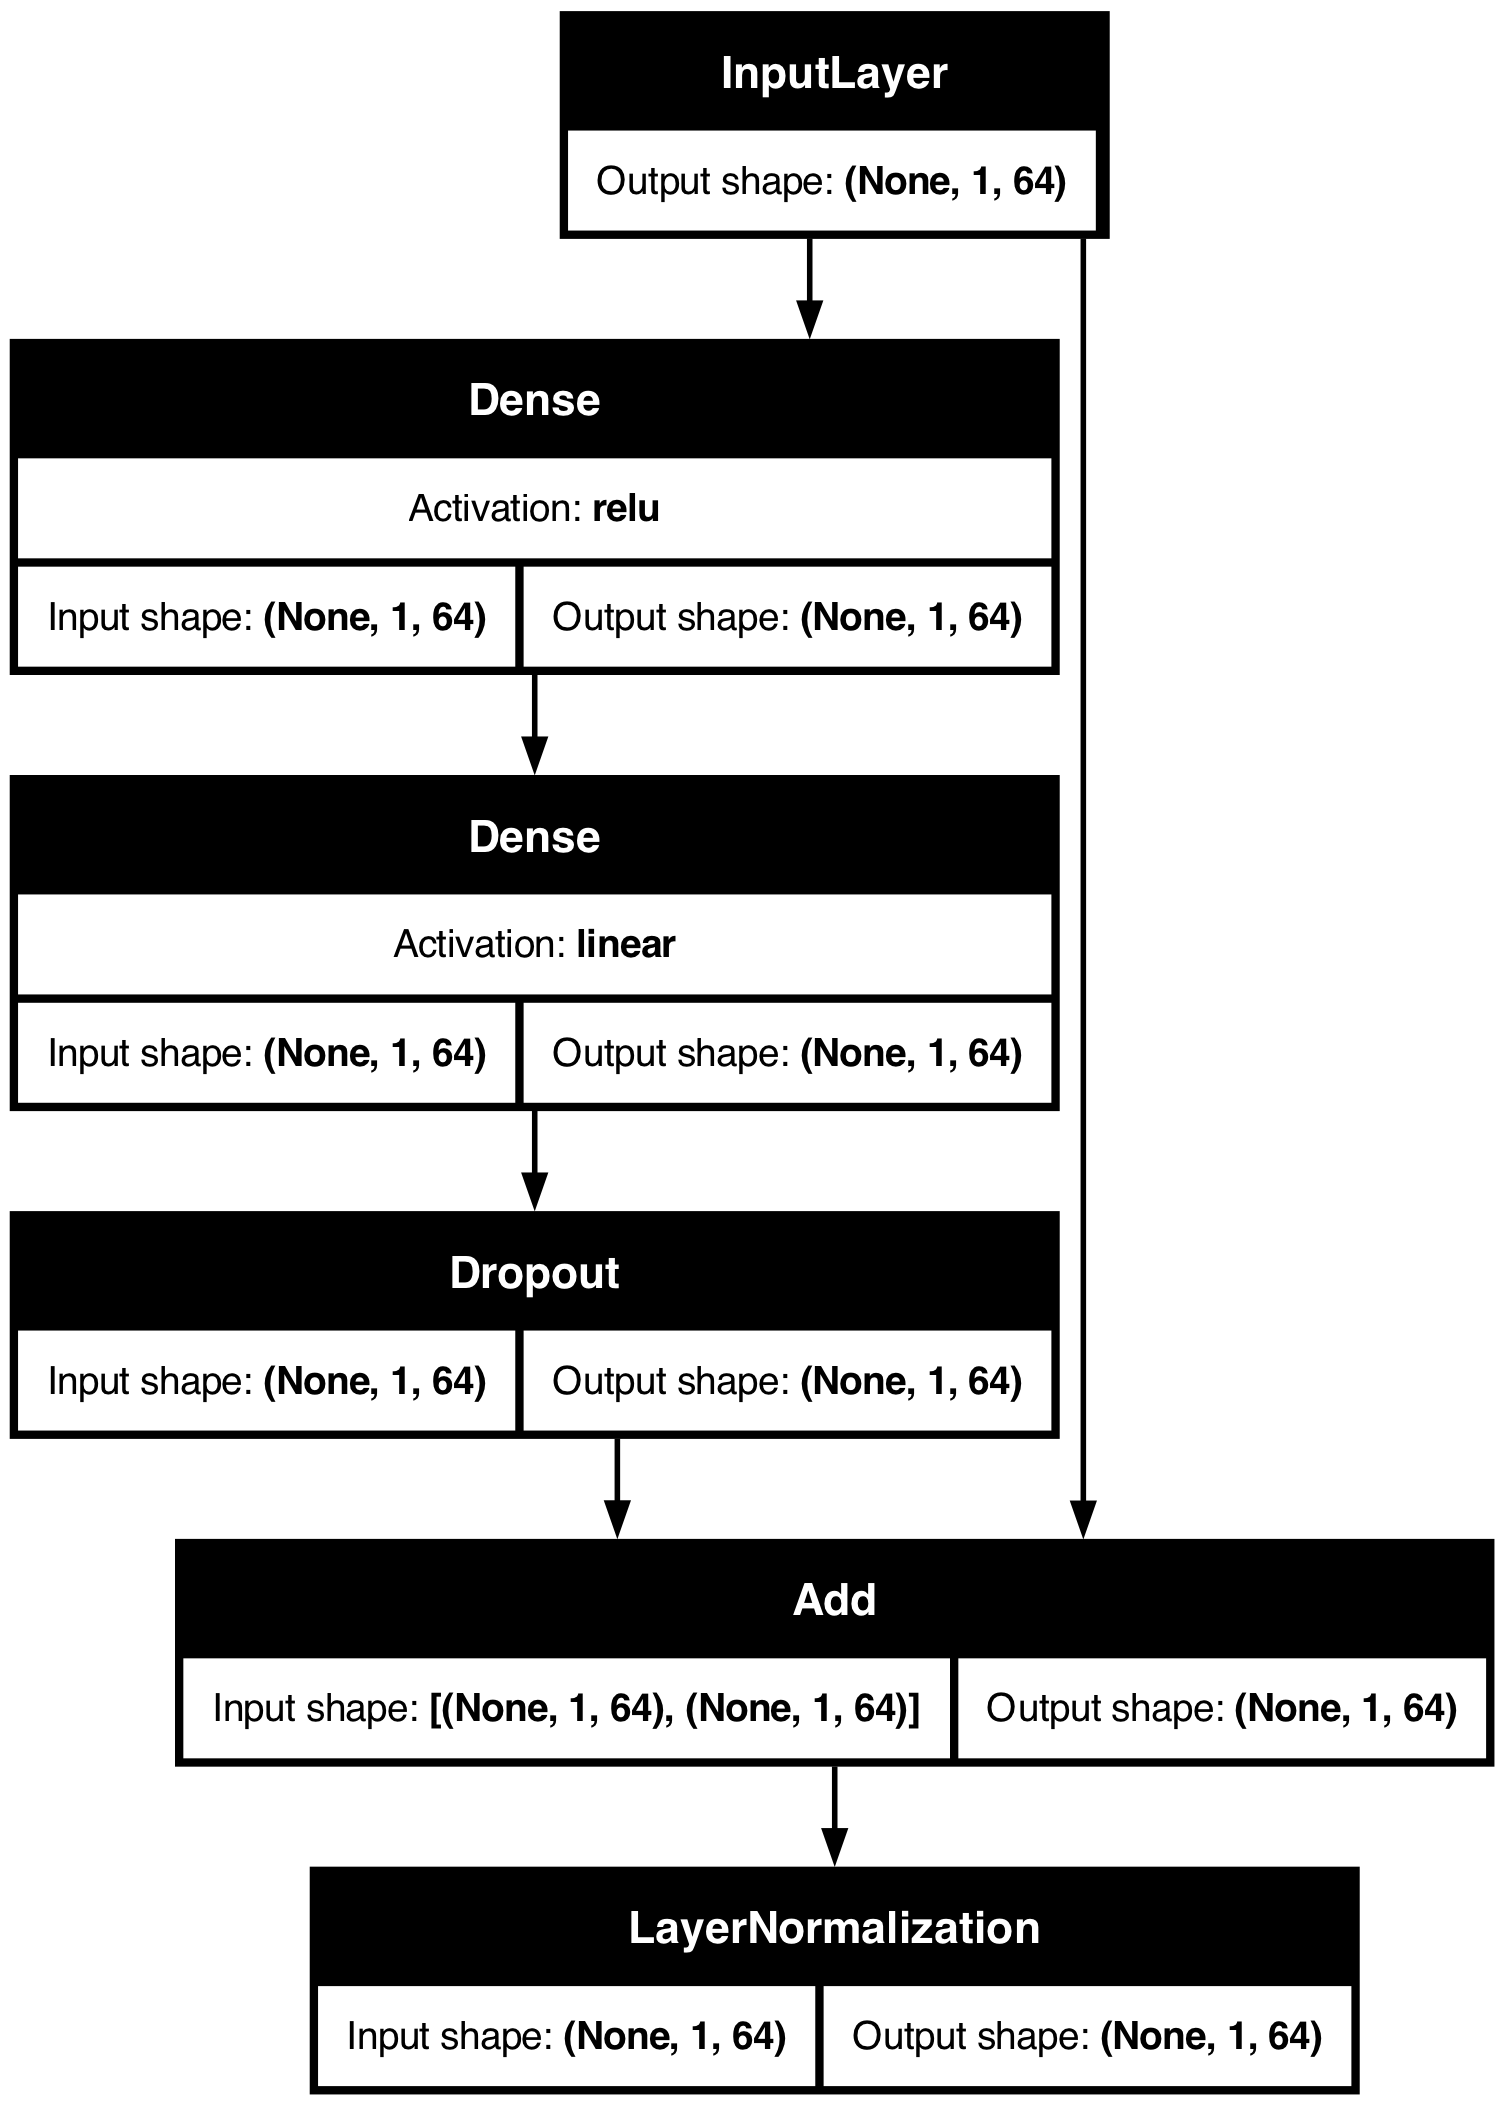

In [ ]:
keras.utils.plot_model(model, 'Tex/figures/FF.png', True, False, show_layer_activations=True, expand_nested=True)

In [36]:
model =tuner.get_best_models(1)[0]
hp = tuner.get_best_hyperparameters()[0]

In [45]:
custom_objects = {
    "FeedForward": FeedForward,
    "GlobalSelfAttention": GlobalSelfAttention,
    "SqueezeAndExcite1D": SqueezeAndExcite1D,
}

In [46]:
model.save('3d.keras')
# ml = saving.load_model('sase.keras', custom_objects= custom_objects)

In [181]:
ytrain = np.load('ytrain.npy')
# ytest = np.load('ytest.npy')
# Xtrain = np.load('npy/PCA/Xtrain.npy')
# Xtest = np.load('npy/PCA/Xtest.npy')

In [48]:
Xtrain = Xtrain.reshape(-1,1,1,3)

In [70]:
Xtest = Xtest.reshape(-1,1,1,3)

In [50]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [194]:

history = model.fit(Xtrain,ytrain, batch_size=256, epochs=2, callbacks=[callback])

Epoch 1/2
18595/18595 ━━━━━━━━━━━━━━━━━━━━ 703s 38ms/step - acc: 0.9575 - auc: 0.9885 - f1_score: 0.9482 - loss: 0.1416 - mIoU: 0.9087
Epoch 2/2
18595/18595 ━━━━━━━━━━━━━━━━━━━━ 711s 38ms/step - acc: 0.9713 - auc: 0.9948 - f1_score: 0.9677 - loss: 0.0833 - mIoU: 0.9377


### NN Testing


In [195]:
yhat = model.predict(Xtest, batch_size=256)

17298/17298 ━━━━━━━━━━━━━━━━━━━━ 84s 5ms/step


In [196]:
metrics = evaluate(ytest, yhat)

In [197]:
metrics

,weighted avg
AUC,0.97
Brier score,0.02
Jaccard score (IoU),0.97
accuracy,0.98
f1-score,0.98
precision,0.98
recall,0.98


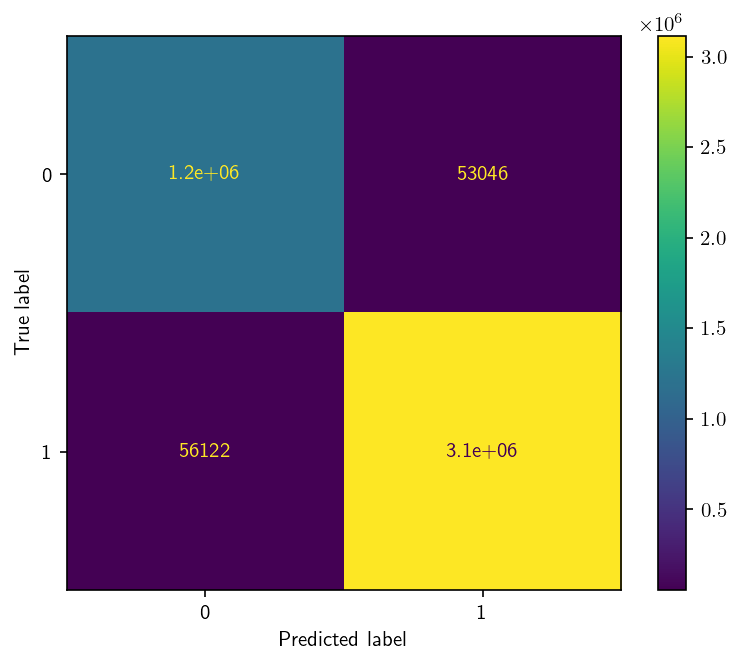

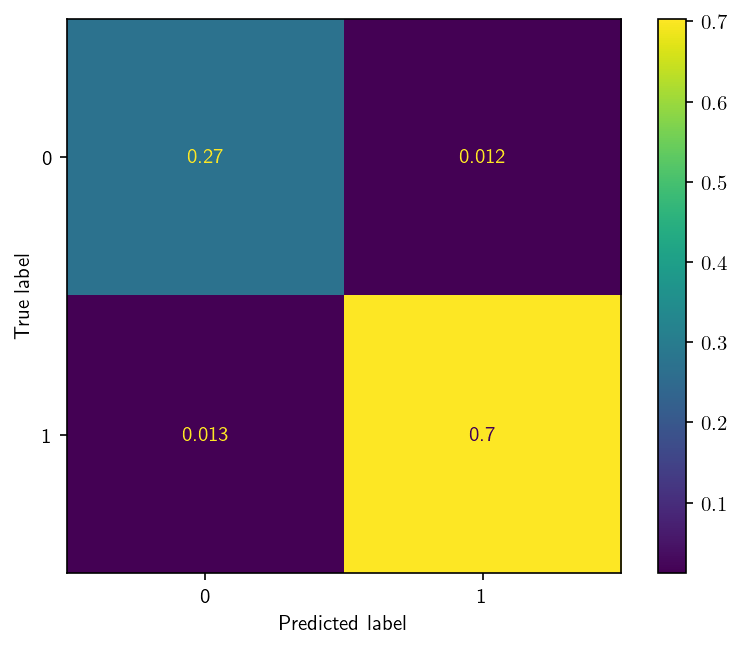

In [198]:
ConfusionMatrixDisplay.from_predictions(np.argmax(ytest, axis=1), np.argmax(yhat, axis=1))
ConfusionMatrixDisplay.from_predictions(np.argmax(ytest, axis=1), np.argmax(yhat, axis=1), normalize='all')

### 3D CNN


In [111]:
#3D CNN testing on PCA
results =[]
# model = saving.load_model('mask.keras')
# Yhat
for i in range(70,71):
        X, y = load(i)
        X, y = preprocess(X, y,3)
        yhat = model.predict(X, batch_size=256)
        metrics = evaluate(y, yhat)
        results.append(metrics)

results = pd.concat(results, axis=1).T
results.mean()
# ConfusionMatrixDisplay.from_predictions(np.argmax(y, axis=1), np.argmax(yhat, axis=1), normalize='all')

433/433 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step


AUC                   0.51
Brier score           0.23
Jaccard score (IoU)   0.77
accuracy              0.77
f1-score              0.68
precision             0.68
recall                0.77
dtype: float64

In [ ]:
# sase.load_weights('sase.weights.h5')
yhat = model.predict(Xtest, batch_size=256)

In [73]:
metrics = evaluate(ytest, yhat)

In [74]:
metrics

,weighted avg
AUC,0.70
Brier score,0.17
Jaccard score (IoU),0.80
accuracy,0.83
f1-score,0.80
precision,0.86
recall,0.83


In [ ]:
ConfusionMatrixDisplay.from_predictions(np.argmax(ytest, axis=1), np.argmax(yhat, axis=1))
ConfusionMatrixDisplay.from_predictions(np.argmax(ytest, axis=1), np.argmax(yhat, axis=1), normalize='all')

## Model Comparison


In [165]:
ytrain = np.argmax(ytrain, axis=1)
ytest = np.argmax(ytest, axis=1)

In [166]:
clf = LazyClassifier(verbose=1,
ignore_warnings=False,
custom_metric=jaccard_score,
predictions = True,
classifiers = [
    DummyClassifier,
    LogisticRegression,
    Perceptron,
    MLPClassifier,
    SGDClassifier,
    DecisionTreeClassifier,
    RandomForestClassifier,
    ]
)
models, predictions = clf.fit(Xtrain, Xtest, ytrain, ytest)
models

 14%|█▍        | 1/7 [00:03<00:22,  3.70s/it]

{'Model': 'DummyClassifier', 'Accuracy': 0.7160127457002456, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.5975180001311703, 'jaccard_score': 0.7160127457002456, 'Time taken': 3.699979066848755}


 29%|██▊       | 2/7 [00:09<00:25,  5.06s/it]

{'Model': 'LogisticRegression', 'Accuracy': 0.9752664763694175, 'Balanced Accuracy': 0.9677746326941962, 'ROC AUC': 0.9677746326941962, 'F1 Score': 0.9752210374127313, 'jaccard_score': 0.9661225920219638, 'Time taken': 6.0074779987335205}


 43%|████▎     | 3/7 [00:16<00:22,  5.66s/it]

{'Model': 'Perceptron', 'Accuracy': 0.9655940616418558, 'Balanced Accuracy': 0.9556075720189894, 'ROC AUC': 0.9556075720189895, 'F1 Score': 0.9655211528239978, 'jaccard_score': 0.9532009240939907, 'Time taken': 6.374337911605835}


 57%|█████▋    | 4/7 [11:45<13:46, 275.49s/it]

{'Model': 'MLPClassifier', 'Accuracy': 0.9745406670039023, 'Balanced Accuracy': 0.9694302811850752, 'ROC AUC': 0.9694302811850751, 'F1 Score': 0.9745592152977373, 'jaccard_score': 0.9650309543889971, 'Time taken': 689.1374170780182}


 71%|███████▏  | 5/7 [11:52<05:57, 178.72s/it]

{'Model': 'SGDClassifier', 'Accuracy': 0.9764057757623934, 'Balanced Accuracy': 0.9716817662486392, 'ROC AUC': 0.9716817662486392, 'F1 Score': 0.9764219920254917, 'jaccard_score': 0.967552914132102, 'Time taken': 7.129645109176636}


 86%|████████▌ | 6/7 [12:40<02:14, 134.23s/it]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.9595540811533458, 'Balanced Accuracy': 0.9478934309357117, 'ROC AUC': 0.9478934309357118, 'F1 Score': 0.9594563854877208, 'jaccard_score': 0.9452305091577075, 'Time taken': 47.86894512176514}


100%|██████████| 7/7 [32:30<00:00, 278.63s/it]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.9737484643734644, 'Balanced Accuracy': 0.9674091077724104, 'ROC AUC': 0.9674091077724104, 'F1 Score': 0.9737401724208118, 'jaccard_score': 0.9640111502710789, 'Time taken': 1190.204128742218}


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,jaccard_score,Time Taken
Model,,,,,,
SGDClassifier,0.98,0.97,0.97,0.98,0.97,6.29
MLPClassifier,0.97,0.97,0.97,0.97,0.97,688.30
LogisticRegression,0.98,0.97,0.97,0.98,0.97,5.13
RandomForestClassifier,0.97,0.97,0.97,0.97,0.96,1189.38
Perceptron,0.97,0.96,0.96,0.97,0.95,5.47
DecisionTreeClassifier,0.96,0.95,0.95,0.96,0.95,46.99
DummyClassifier,0.72,0.50,0.50,0.60,0.72,2.83


In [167]:
metrics.rename({'weighted avg': 'SASE'},  axis=1)

,SASE
AUC,0.97
Brier score,0.03
Jaccard score (IoU),0.97
accuracy,0.97
f1-score,0.97
precision,0.97
recall,0.97


In [168]:
predictions.columns = ['DummyClassifier', 'Logistic Regression', 'Perceptron', 'MLP', 'SVM', 'Decision Tree', 'Random Forest']

In [169]:
for model in predictions.columns:
    metrics[model] = evaluate(ytest, predictions[model])

In [170]:
metrics

,weighted avg,DummyClassifier,Logistic Regression,Perceptron,MLP,SVM,Decision Tree,Random Forest
AUC,0.97,0.50,0.97,0.96,0.97,0.97,0.95,0.97
Brier score,0.03,0.28,0.02,0.03,0.03,0.02,0.04,0.03
Jaccard score (IoU),0.97,0.72,0.97,0.95,0.97,0.97,0.95,0.96
accuracy,0.97,0.72,0.98,0.97,0.97,0.98,0.96,0.97
f1-score,0.97,0.60,0.98,0.97,0.97,0.98,0.96,0.97
precision,0.97,0.51,0.98,0.97,0.97,0.98,0.96,0.97
recall,0.97,0.72,0.98,0.97,0.97,0.98,0.96,0.97


## Visual Assessment


spectral:INFO: k-means iteration 1 - 99 pixels reassigned.
spectral:INFO: k-means iteration 2 - 151 pixels reassigned.
spectral:INFO: k-means iteration 3 - 1148 pixels reassigned.
spectral:INFO: k-means iteration 4 - 10406 pixels reassigned.
spectral:INFO: k-means iteration 5 - 11544 pixels reassigned.
spectral:INFO: k-means iteration 6 - 1586 pixels reassigned.
spectral:INFO: k-means iteration 7 - 306 pixels reassigned.
spectral:INFO: k-means iteration 8 - 58 pixels reassigned.
spectral:INFO: k-means iteration 9 - 9 pixels reassigned.
spectral:INFO: k-means iteration 10 - 3 pixels reassigned.
spectral:INFO: k-means iteration 11 - 0 pixels reassigned.
spectral:INFO: kmeans terminated with 2 clusters after 10 iterations.


433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


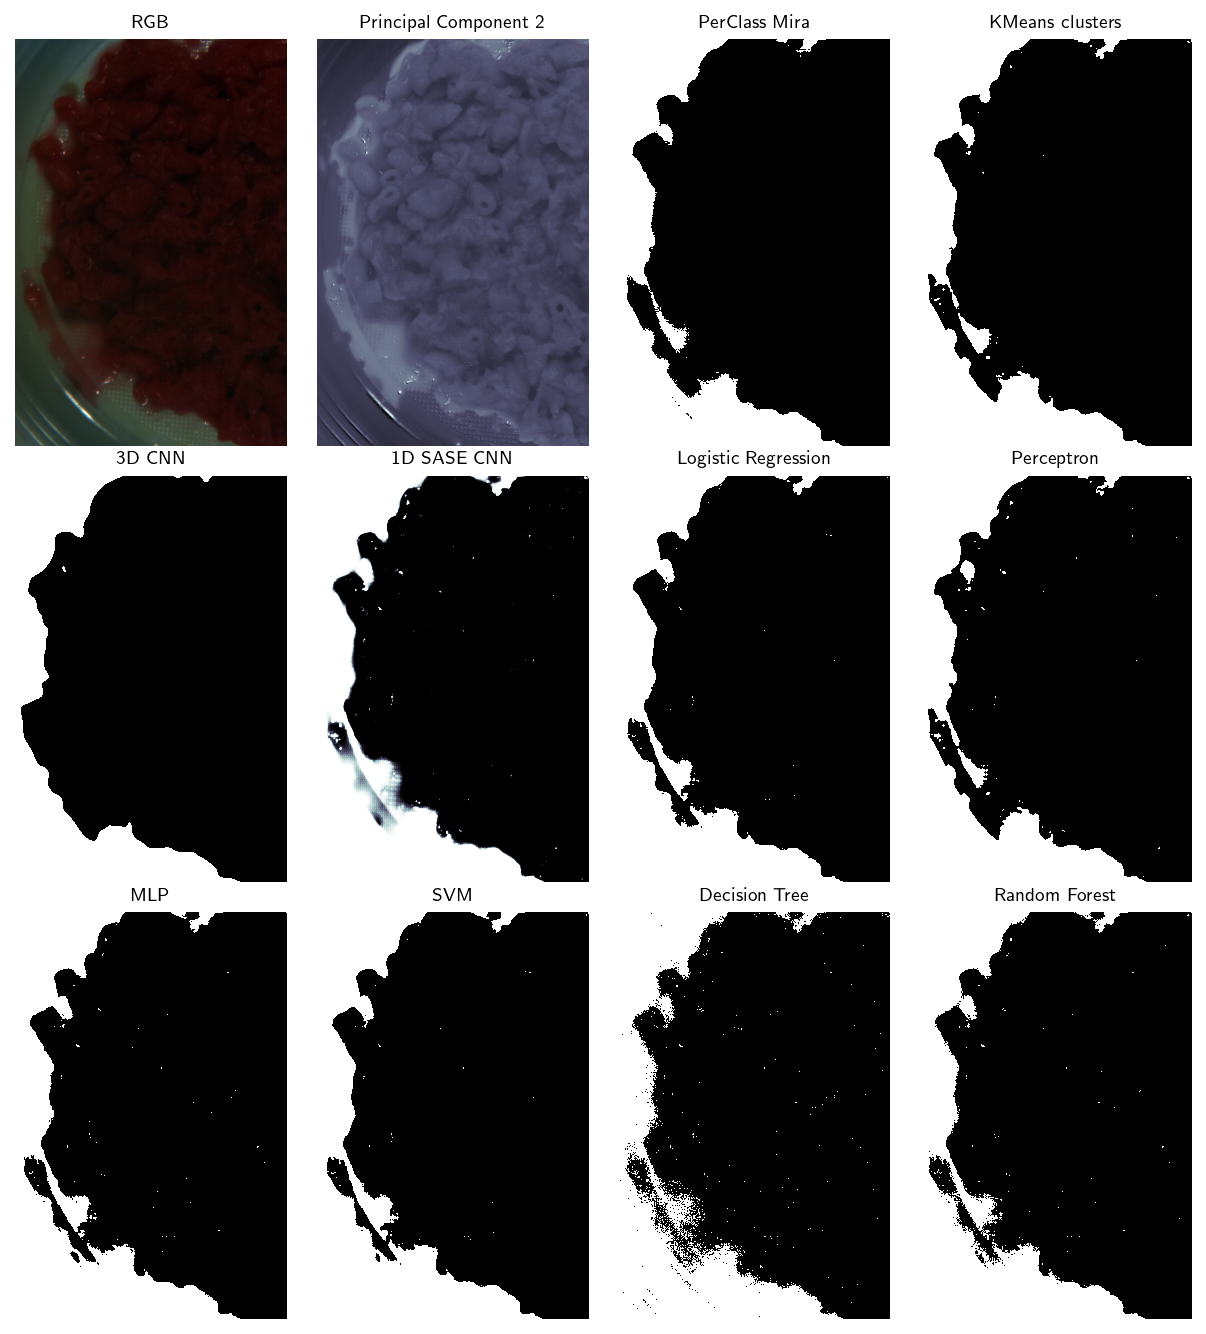

In [87]:
for i in range(70,71):
    plt.close('all')
    # Load the RGB image
    rgb = io.imread(f'rgb{i}.png')
    im1 = [rgb, "RGB"]
    
    # Loaddd and preprocess data
    X, y = load(i)
    X = apply_PCA(X, 2)
    im2 = [X.reshape(407, 272, 2)[:, :, 1], "Principal Component 2"]
    
    # Load and preprocess ground truth image
    y = skimage.color.rgb2gray(y)
    y = skimage.exposure.adjust_gamma(y, 1)
    y[np.where(y>0.5)] = 1
    y[np.where(y<0.5)] = 0
    im3 = [y, "PerClass Mira"]
    
    X, y = load(i)
    # Perform KMeans clustering
    m, c = spectral.kmeans(X, 2, 20)
    im4 = [m, "KMeans clusters"]
    
    y = io.imread(f"masks/m{i}_mask.png").T
    # Placeholder for 3D CNN result (you need to replace this with actual result)
    im5 = [1 - y, "3D CNN"]
    
    # Preprocess for SASE model and make prediction
    X, y = load(i)
    X, y = preprocess(X, y, 3)
    yhat = sase.predict(X, batch_size=256)
    im6 = [1 -yhat[:, 1].reshape(407, 272), "1D SASE CNN"]
    
    # List to hold all images and titles
    images = [im1, im2, im3, im4, im5, im6]
    
    num_samples_per_image = X.shape[0]

    j = 0
    start_idx = j * num_samples_per_image
    end_idx = start_idx + num_samples_per_image
    
    # Iterate over model predictions
    for model in predictions.columns:
        if model =='DummyClassifier':
            continue
        else:
            pred = predictions[model].iloc[start_idx:end_idx]
            pred = 1 - np.reshape(pred, (407, 272))
            images.append([pred, f"{model}"])
    
    # Create a figure and image grid
    fig = plt.figure(figsize=(9, 9))
    grid = ImageGrid(fig, 111, (3, 4), axes_pad=0.2)
    
    # Plot all images in the grid
    for ax, im in zip(grid, images):
        ax.imshow(im[0], cmap = 'bone')  # Assuming grayscale images for simplicity
        ax.set_title(im[1], fontsize=9)
        ax.set_axis_off()
    
    fig.tight_layout()
    fig.savefig(f"./Tex/figures/sase_pasta{i}.svg")

In [57]:
metrics = []
for i in range(70,111):
    y = io.imread(f"mats/m{i}_corrected.png")
    y = skimage.color.rgb2gray(y).T
    y = skimage.exposure.adjust_gamma(y, 1)
    y[np.where(y>0.5)] = 1
    y[np.where(y<0.5)] = 0
    yhat = 1-io.imread(f"masks/m{i}_mask.png")
    metrics = evaluate(y.flatten(), yhat.flatten())


In [58]:
metrics

,weighted avg
AUC,0.97
Brier score,0.03
Jaccard score (IoU),0.94
accuracy,0.97
f1-score,0.97
precision,0.97
recall,0.97
